In [2]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import the code from Afresh

In [3]:
# Clearly, this problem needs order_cost < under_order_cost , otherwise we’ll never order cereal.

## TODO: MYPY!

def get_cost(inventory, order, order_cost= 2, over_order_cost=4, under_order_cost=5):
    over_order_cost = max(inventory, 0) * over_order_cost
    under_order_cost = -min(inventory, 0) * under_order_cost
    return over_order_cost + under_order_cost + order * order_cost

def act_and_get_cost(inventory, order, demand):
    # possibly negative  
    resulting_inventory = inventory + order - demand
    cost = get_cost(inventory, order)
    next_inventory = max(resulting_inventory, 0)
    return next_inventory, cost

In [4]:
act_and_get_cost(10, 5, 1)

(14, 50)

In [5]:


class NonPerishableDPSolver:
    def __init__(self,
                 over_order_cost: float,
                 under_order_cost: float,
                 fixed_order_cost: float):
        self.over_order_cost = over_order_cost
        self.under_order_cost = under_order_cost
        self.fixed_order_cost = fixed_order_cost

    def cost_function(self, state, order):
        over_order_cost = max(state, 0) * self.over_order_cost
        under_order_cost = -min(state, 0) * self.under_order_cost
        order_cost = self.fixed_order_cost * order
        return over_order_cost + under_order_cost + order_cost

    def act(self, state: float, shipment: float, sales: float) -> Tuple[float, float]:
        resulting_state = state + shipment - sales
        cost = self.cost_function(resulting_state, shipment)
        resulting_state = max(resulting_state, 0)
        return resulting_state, cost
    
    def dp_solve(self, forecasts: np.array, verbose: bool = False):
        T = forecasts.shape[0] # these are days
        max_order = forecasts.shape[1] # forecasts are the probability of that order being made, each col is an order amount
        print(max_order, 'max_order')
        
        inventory_max = max_order * (T + 1)
        print(inventory_max, 'inventory_max')
        inventory_max_opt = max_order * T
        print(inventory_max_opt, 'inventory_max_opt')
        
        matrix_size = (T + 1, inventory_max) 
        matrix_size_opt = (T, inventory_max)
        
        explain_array = np.zeros((T, inventory_max, max_order))
        path_array = np.full(matrix_size, -1, dtype=np.int32)
        cost_array = np.full(matrix_size_opt, np.inf)
        # cost_array[-1, :] = 0 # cost of the initial state is 0
        
        for t in range(T - 1, -1, -1):
            print(t, 'T')
            for inv in range(inventory_max_opt):
                if verbose:
                    print(inv,' inventory')
                best_order = -1
                best_cost = np.inf
                for order in range(max_order):
                    cost = 0
                    if verbose:
                        print(order, 'order')
                    for forecast in range(max_order): #
                        
                        forecast_prob = forecasts[t, forecast]

                        # forecast here is used as shipment
                        state, prob_cost = self.act(inv, order, forecast)
                        if t+1 == T:
                            resultant_cost = 0
                        else:
                            resultant_cost = cost_array[t + 1, state] #this is the terminal cost for this state, we accumulate this through days based upon the inventory levels present
                        
                        # prob cost is the cost of the forecast of a given amount of demand
                        # resultant cost is looking at the previous days cost given this amount of inventory
                        cost += forecast_prob * (prob_cost + resultant_cost)
                        if verbose:
                            print(state, prob_cost, 'state, prob_cost')
                            print(forecast, 'forecast')
                            print(forecast, 'forecast')
                            print(forecast_prob, 'forecast_prob')
                            print(resultant_cost, 'resultant_cost')
                            print(cost,'cost')
                            print('---')
                    explain_array[t, inv, order] = cost
                    if cost < best_cost:
                        best_cost = cost
                        best_order = order
                path_array[t, inv] = best_order
                cost_array[t, inv] = best_cost
        return explain_array, path_array, cost_array

In [6]:
# 2 days of forecasts, 5 possible values
forecasts_unnormalized = np.random.random((2, 5))
# Normalize to make probabilities:
# This is used for the percent of total inventory that is demanded
forecasts = forecasts_unnormalized / np.expand_dims(forecasts_unnormalized.sum(axis=1), 1)
# Solve
solver =  NonPerishableDPSolver(over_order_cost=2,under_order_cost= 6, fixed_order_cost=0)

In [7]:
# path_array, optimal order in this state
# cost array, cost in this state
explain_array, path_array, cost_array = solver.dp_solve(forecasts, verbose=True)

5 max_order
15 inventory_max
10 inventory_max_opt
1 T
0  inventory
0 order
0 0 state, prob_cost
0 forecast
0 forecast
0.08812953269121315 forecast_prob
0 resultant_cost
0.0 cost
---
0 6 state, prob_cost
1 forecast
1 forecast
0.1742544063833031 forecast_prob
0 resultant_cost
1.0455264382998186 cost
---
0 12 state, prob_cost
2 forecast
2 forecast
0.3165265831957341 forecast_prob
0 resultant_cost
4.843845436648628 cost
---
0 18 state, prob_cost
3 forecast
3 forecast
0.2651004041054488 forecast_prob
0 resultant_cost
9.615652710546707 cost
---
0 24 state, prob_cost
4 forecast
4 forecast
0.15598907362430076 forecast_prob
0 resultant_cost
13.359390477529924 cost
---
1 order
1 2 state, prob_cost
0 forecast
0 forecast
0.08812953269121315 forecast_prob
0 resultant_cost
0.1762590653824263 cost
---
0 0 state, prob_cost
1 forecast
1 forecast
0.1742544063833031 forecast_prob
0 resultant_cost
0.1762590653824263 cost
---
0 6 state, prob_cost
2 forecast
2 forecast
0.3165265831957341 forecast_prob
0 res

In [8]:
# 10 days of forecasts, 15 possible values
forecasts_unnormalized = np.random.random((10, 15))
# Normalize to make probabilities:
# This is used for the percent of total inventory that is demanded
forecasts = forecasts_unnormalized / np.expand_dims(forecasts_unnormalized.sum(axis=1), 1)
# Solve
solver = NonPerishableDPSolver(over_order_cost=2,under_order_cost= 6, fixed_order_cost=0)

# path_array, optimal order in this state
# cost array, cost in this state
explain_array, path_array, cost_array = solver.dp_solve(forecasts)

15 max_order
165 inventory_max
150 inventory_max_opt
9 T
8 T
7 T
6 T
5 T
4 T
3 T
2 T
1 T
0 T


In [9]:
cost_array.shape # why is there 11 here?

(10, 165)

In [10]:
forecasts.shape

(10, 15)

In [11]:
path_array.shape

(11, 165)

In [12]:
explain_array.shape

(10, 165, 15)

## Forecasts

In [13]:
forecasts

array([[0.08023091, 0.10841413, 0.02421144, 0.01645291, 0.08994682,
        0.00418964, 0.11135035, 0.0322934 , 0.05111866, 0.1104158 ,
        0.08556379, 0.06821459, 0.06785547, 0.06140763, 0.08833445],
       [0.10688064, 0.10654096, 0.08194538, 0.03756711, 0.08622891,
        0.15989504, 0.05543081, 0.01268243, 0.00249631, 0.00185531,
        0.15307489, 0.0866558 , 0.00639746, 0.05911091, 0.04323805],
       [0.02995245, 0.09594697, 0.06419656, 0.05951244, 0.05925515,
        0.008972  , 0.07034793, 0.02439267, 0.15085926, 0.03298429,
        0.04345516, 0.0339289 , 0.05881434, 0.13439123, 0.13299064],
       [0.01150462, 0.05044515, 0.07765762, 0.03501937, 0.04677044,
        0.04228852, 0.00772349, 0.13621637, 0.14594244, 0.03914499,
        0.13720456, 0.00847925, 0.12719304, 0.08585732, 0.04855281],
       [0.1110163 , 0.10626987, 0.00090652, 0.05544436, 0.10891539,
        0.02685667, 0.10165722, 0.01972561, 0.02437476, 0.0852227 ,
        0.04503421, 0.07837837, 0.07874352, 

Text(0.5, 0.98, 'Inventory Count at time zero')

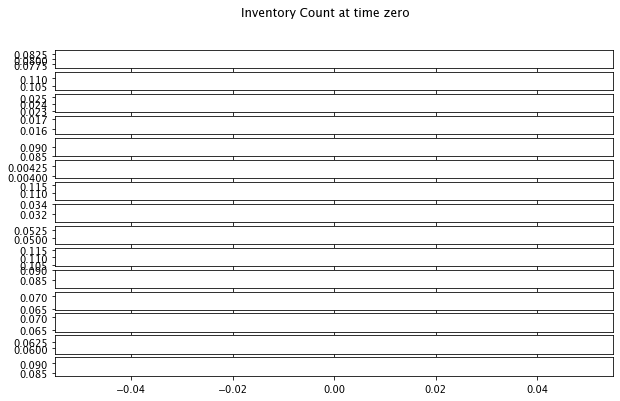

In [14]:
fig, ax = plt.subplots( len(forecasts[0,:]), squeeze=True, figsize=(10,6))

for inventory_count in range(len(forecasts[0, :])): # x is day, y is inventory
    ax[inventory_count].plot(forecasts[0, inventory_count])
fig.suptitle('Inventory Count at time zero') 

    



## Cost

In [15]:
cost_array

array([[111.50722659, 111.50722659, 111.50722659, ...,          inf,
                 inf,          inf],
       [100.50483886, 100.50483886, 100.50483886, ...,          inf,
                 inf,          inf],
       [ 88.7470751 ,  88.7470751 ,  88.7470751 , ...,          inf,
                 inf,          inf],
       ...,
       [ 34.50842816,  34.50842816,  34.50842816, ...,          inf,
                 inf,          inf],
       [ 22.96742513,  22.96742513,  22.96742513, ...,          inf,
                 inf,          inf],
       [ 11.04775463,  11.04775463,  11.04775463, ...,          inf,
                 inf,          inf]])

In [16]:
cost_array[-1, :50]

array([11.04775463, 11.04775463, 11.04775463, 11.04775463, 11.04775463,
       11.04775463, 11.04775463, 11.04775463, 11.04775463, 11.04775463,
       11.04775463, 11.04775463, 11.04775463, 11.61879898, 12.89936925,
       14.89936925, 16.89936925, 18.89936925, 20.89936925, 22.89936925,
       24.89936925, 26.89936925, 28.89936925, 30.89936925, 32.89936925,
       34.89936925, 36.89936925, 38.89936925, 40.89936925, 42.89936925,
       44.89936925, 46.89936925, 48.89936925, 50.89936925, 52.89936925,
       54.89936925, 56.89936925, 58.89936925, 60.89936925, 62.89936925,
       64.89936925, 66.89936925, 68.89936925, 70.89936925, 72.89936925,
       74.89936925, 76.89936925, 78.89936925, 80.89936925, 82.89936925])

Text(0, 0.5, 'cost')

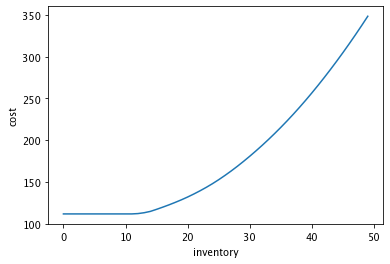

In [17]:
plt.plot(cost_array[0, :50])
plt.xlabel('inventory')

plt.ylabel('cost')

Text(0.5, 0.98, 'Cost per day. each plot is a day, x axis is cost')

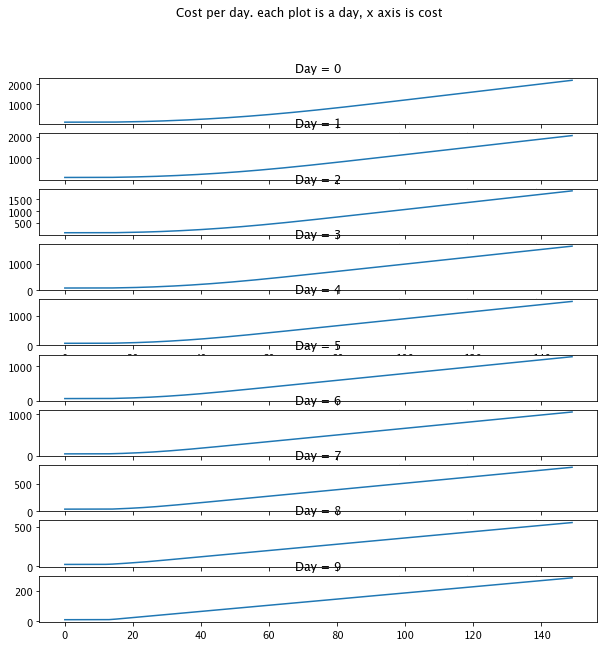

In [18]:
n_days =  cost_array.shape[0]
fig, ax = plt.subplots(n_days, squeeze=True, figsize=(10,10)) # x axis is day, y axis is inventory

for day_n in range(n_days):
    ax[day_n].plot(cost_array[day_n, :])
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[day_n].set_title(f"Day = {day_n}")

fig.suptitle('Cost per day. each plot is a day, x axis is cost') 
    



In [19]:
## at T=

### Path

In [373]:
path_array.shape

(11, 165)

Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

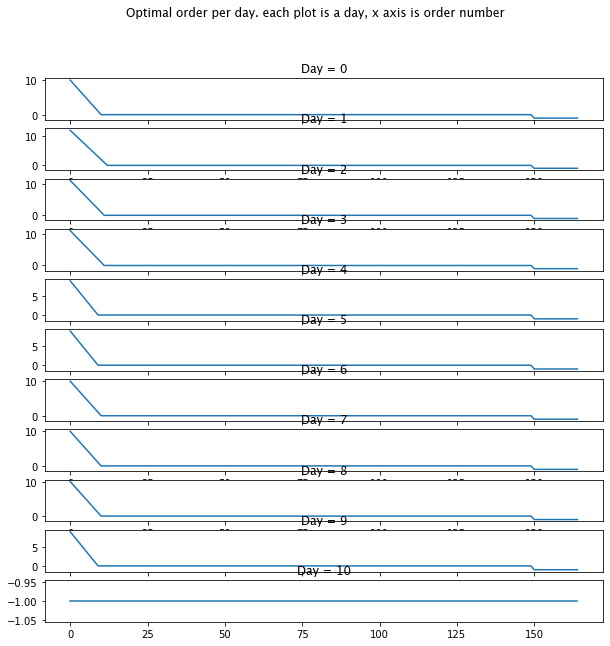

In [374]:
n_days =  path_array.shape[0]
fig, ax = plt.subplots(n_days, squeeze=True, figsize=(10,10)) # x axis is day, y axis is inventory

for day_n in range(n_days):
    ax[day_n].plot(path_array[day_n, :])
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[day_n].set_title(f"Day = {day_n}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



## Path vs Cost

### Explain Array

In [375]:
explain_array.shape # Time, Inventory, Order

(10, 165, 15)

Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

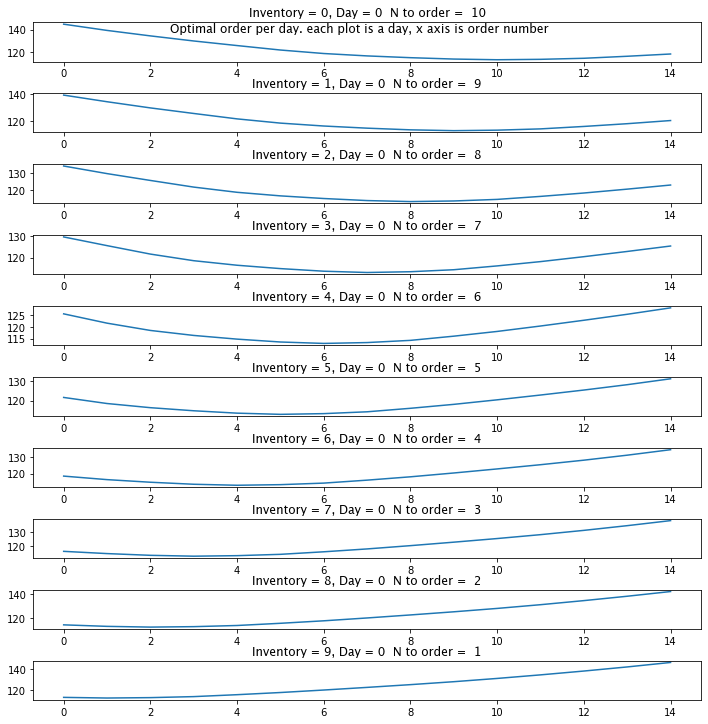

In [376]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 0
fig, ax = plt.subplots(inventory_n, figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



In [377]:
print("For day T=0, we want to have a total of 10 items")

For day T=0, we want to have a total of 10 items


Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

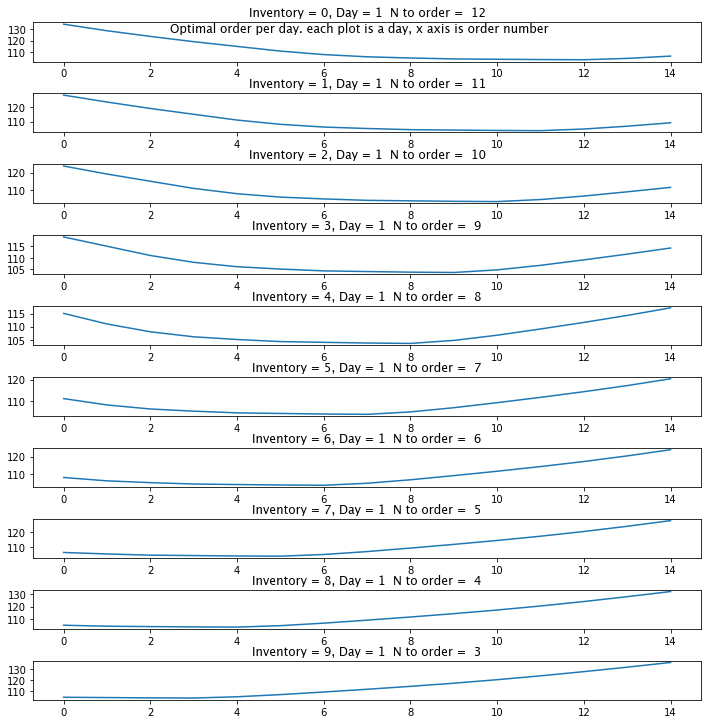

In [378]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 1
fig, ax = plt.subplots(inventory_n,  figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



In [169]:
print("For day T=1, we want to have a total of 10 items")

For day T=1, we want to have a total of 10 items


Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

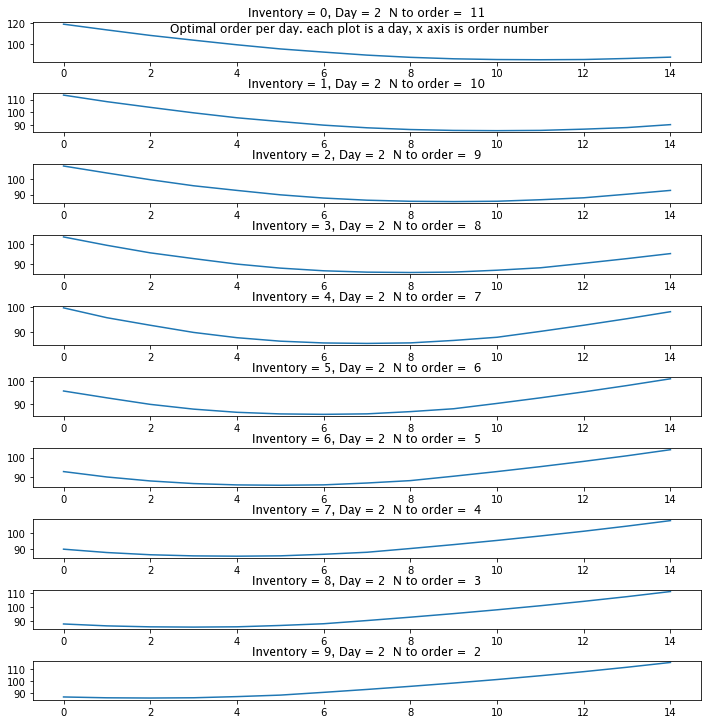

In [165]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 2
fig, ax = plt.subplots(inventory_n,  figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



In [170]:
print("For day T=12 we want to have a total of 11 items")

For day T=12 we want to have a total of 11 items


Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

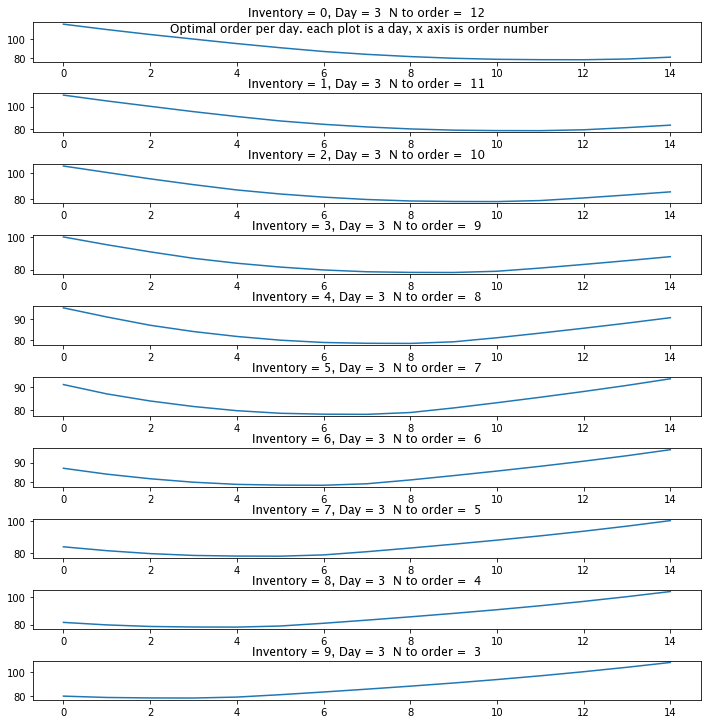

In [276]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 3
fig, ax = plt.subplots(inventory_n,  figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



In [277]:
print("For day T=3 we want to have a total of 12 items")

For day T=3 we want to have a total of 12 items


# Add blueberries

In [48]:


def get_sales(state: np.array, total_sales: int):
    """Given total_sales, allocate them in a FIFO manner"""
    # state is vector if blueberry ages
    for i in range(max_age, 0):
        sale = min(state[i], total_sales) # can sell more than what is in nstock
        total_sales -= sale
        state[i] = state[i] - sale
    return total_sales # lost sales


def transition(state):
    """Every item of age k ages into k+1, oldest items go to
     waste"""
     
     ## TODO: markov matrix here
    last = 0
    tmp = 0
    for i in range(max_age):
        tmp = state[i]
        state[i] = last
        last = tmp
    return last # waste


def act(state, shipment, sales):
    "Given a shipment and sales, transform the state"
    state[0] = shipment
    lost_sales = get_sales(state, sales)
    waste = transition(state)
    
    print(f"Lost sales = {lost_sales}, Waste = {waste}")
    print(f"State = {state}")

In [49]:
max_age = 5
max_inventory = 3

blueberry_vector = np.random.randint(max_inventory, size=(max_age))

In [50]:
blueberry_vector # each col is a day, each row is a state where a state is the number of bluberries at this age

array([0, 2, 1, 1, 2])

In [57]:
act(blueberry_vector, shipment=2, sales=1)

Lost sales = 1, Waste = 2
State = [0 2 2 2 2]


In [83]:


class PerishableDPSolver:
    def __init__(self,
                 over_order_cost: float,
                 under_order_cost: float,
                 fixed_order_cost: float,
                 max_age: float):
        self.over_order_cost = over_order_cost
        self.under_order_cost = under_order_cost
        self.fixed_order_cost = fixed_order_cost
        self.max_age = max_age

    def cost_function(self, state, order):
        over_order_cost = max(state, 0) * self.over_order_cost
        under_order_cost = -min(state, 0) * self.under_order_cost
        order_cost = self.fixed_order_cost * order
        return over_order_cost + under_order_cost + order_cost

    # def act(self, state: float, shipment: float, sales: float) -> Tuple[float, float]:
    #     resulting_state = state + shipment - sales
    #     cost = self.cost_function(resulting_state, shipment)
    #     resulting_state = max(resulting_state, 0)
    #     return resulting_state, cost
    
    
    
    def get_sales(self, state: np.array, total_sales: int) -> int:
        """Given total_sales, allocate them in a FIFO manner"""
        # state is vector of blueberry ages
        for i in range(self.max_age, 0):
            sale = min(state[i], total_sales) # can sell more than what is in nstock
            total_sales -= sale # allocate sales accroding to age
            state[i] = state[i] - sale
        return total_sales, state # lost sales


    def transition(self, state: np.array) -> Tuple[int, np.array]:
        """Every item of age k ages into k+1, oldest items go to
        waste"""
        
        ## TODO: markov matrix here
        last = 0
        tmp = 0
        for i in range(self.max_age):
            tmp = state[i]
            state[i] = last
            last = tmp
        return last, state # waste, updated state


# def act(state, shipment, sales):
#     "Given a shipment and sales, transform the state"""
#     state[0] = shipment
#     lost_sales = get_sales(state)
#     waste = transition(state)
    
    def act(self, state, shipment, sales):
        "Given a shipment and sales, transform the state"
        state[0] = shipment # shipmennts are fresh blueberries, go into the first age col
        lost_sales, updated_with_sales_state = self.get_sales(state, sales)
        waste, updated_with_transition_state = self.transition(updated_with_sales_state)
        
        total_lost_sales = lost_sales + waste
        
        # print(f"Lost sales = {lost_sales}, Waste = {waste}")
        # print(f"State = {state}")
        cost = self.cost_function(total_lost_sales, shipment)
        
        resulting_state = np.sum(updated_with_transition_state)
        
        # resulting_state should be the level of inventory we have left
        
        return resulting_state, cost, updated_with_transition_state
        
    
    
    def dp_solve(self, forecasts: np.array, verbose: bool = False):
        T = forecasts.shape[0] # these are days
        max_order = forecasts.shape[1] # forecasts are the probability of that order being made, each col is an order amount
        print(max_order, 'max_order')
        
        inventory_max = max_order * (T + 1)
        print(inventory_max, 'inventory_max')
        inventory_max_opt = max_order * T
        print(inventory_max_opt, 'inventory_max_opt')
        
        matrix_size = (T + 1, inventory_max, self.max_age)
        # matrix_size_opt = (T, inventory_max)
        
        explain_array = np.zeros((T, inventory_max, max_order, self.max_age))
        path_array = np.full(matrix_size, -1, dtype=np.int32)
        cost_array = np.full(matrix_size, np.inf)
        # blueberry_state = np.zeros(matrix_size)
        # cost_array[-1, :] = 0 # cost of the initial state is 0
        
        for t in range(T - 1, -1, -1):
            print(t, 'T')
            for shelf_life in range(self.max_age, 0):
                print(shelf_life, 'shelf_life')
                
                blueberry_state = np.zeros(shelf_life)
                
                for inv in range(inventory_max_opt):
                    if verbose:
                        print(inv,' inventory')
                    best_order = -1
                    best_cost = np.inf
                    
                    
                
                    
                    for order in range(max_order):
                        cost = 0
                        if verbose:
                            print(order, 'order')
                        for forecast in range(max_order): #
                            
                            forecast_prob = forecasts[t, forecast]

                            # forecast here is used as shipment
                            state, prob_cost, blueberry_state = self.act(blueberry_state, order, forecast)
                            print(blueberry_state, 'blueberry_state')
                            if t+1 == T:
                                resultant_cost = 0
                            else:
                                resultant_cost = cost_array[t + 1, state, shelf_life] #this is the terminal cost for this state, we accumulate this through days based upon the inventory levels present
                            
                            # prob cost is the cost of the forecast of a given amount of demand
                            # resultant cost is looking at the previous days cost given this amount of inventory
                            cost += forecast_prob * (prob_cost + resultant_cost)
                            if verbose:
                                print(state, prob_cost, 'state, prob_cost')
                                print(forecast, 'forecast')
                                print(forecast, 'forecast')
                                print(forecast_prob, 'forecast_prob')
                                print(resultant_cost, 'resultant_cost')
                                print(cost,'cost')
                                print('---')
                        explain_array[t, inv, order, shelf_life] = cost
                        if cost < best_cost:
                            best_cost = cost
                            best_order = order
                    path_array[t, inv, shelf_life] = best_order
                    cost_array[t, inv, shelf_life] = best_cost
        return explain_array, path_array, cost_array

In [86]:
# 10 days of forecasts, 15 possible values
forecasts_unnormalized = np.random.random((10, 15))
# Normalize to make probabilities:
# This is used for the percent of total inventory that is demanded
forecasts = forecasts_unnormalized / np.expand_dims(forecasts_unnormalized.sum(axis=1), 1)
# Solve
solver = PerishableDPSolver(over_order_cost=2,under_order_cost= 2, fixed_order_cost=1.75, max_age=3)

# path_array, optimal order in this state
# cost array, cost in this state
explain_array, path_array, cost_array = solver.dp_solve(forecasts, verbose=True)

15 max_order
165 inventory_max
150 inventory_max_opt
9 T
8 T
7 T
6 T
5 T
4 T
3 T
2 T
1 T
0 T


In [79]:
explain_array.sum()

0.0